In [3]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical_high_N.json') as json_file:
    data_as_is_analytical_high_N = json.load(json_file)

# Opening JSON file
with open('data_10yr.json') as json_file:
    data_10yr = json.load(json_file)    

Before Christmas we developed a simple experiment using the analytical M(t)/M/s(t) queueing model to compare different development solutions. Over a 10 year period, we built a baseline number of housing and shelter units, and then we gave ourselves an extra bit of budget which had to be spent in one of the first four years, either on extra housing or on extra shelter. The extra budget was worth 60 housing units. So when we decided to spend this extra budget on housing, we would build 60 extra housing units in a given year. If we decided to spend the extra budget on shelter, the amount of shelter units we could build depends on the cost of shelter compared to housing. 

We found that when we spent our extra budget on shelter, the benefits to the unsheltered Q were as a direct result of people leaving the unsheltered Q. The cheaper the shelter, the more people could leave the unsheltered Q, and the bigger the benefit. 

When we spent our extra budget on housing, the benefits to the unsheltered Q were indirectly a consequence of people leaving the sheltered Q and thereby creating space for people to leave the unsheltered Q. Furthermore, the extra housing increased the number of servers, hence increasing the rate of people leaving the system, which had a knock-on benefit for the size of the unsheltered Q. The greater the housing service rate, the greater the benefit. 

The effect of the increased service rate which came from extra housing was not immediate (time must pass for people to be served), and this delay meant that if one decided to build housing at later point in time (over the finite 10 year horizon), the benefit wore off more quickly than if one decided to build shelter at a later point. Consequently, in certain model configurations (including specific values of the cost of shelter and the housing service rate) we found that if we decided to spend our extra budget earlier, we would prefer housing, but if we decided to spend our extra budget later, we would prefer shelter. Such a configuration is illustrated below, with an objective function of $\mathbb{E}[Mean size of unsheltered Q]$. 

The model parameters below should be noted. 

In [7]:
# Explore range of shelter costs and service time distributions
# print('start at time ' + str(datetime.datetime.now()))
b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 36]
service_times = [2]

In [14]:
print('Initial number in system: ' + str(data_10yr['initial_demand']))
print('Initial capacity: ' + str(data_10yr['initial_capacity']))
print('Arrival rate in each year: ' + str(data_10yr['arrival_rates'][0]))
print('Baseline extra housing units to build per year: ' + str(b))
print('Baseline extra shelter units to build per year: ' + str(s))
print('Model run horizon: ' + str(data_10yr['analysis_horizon']) + ' years')
print('Decision horizon: ' + str(yrs_dec) + ' years')
print('Cost of shelter (as proportion of housing): ' + str(round(hx/additional_shelter[0],2)))
print('Housing service rate: ' + str(round(1/service_times[0],2)))

Initial number in system: 140
Initial capacity: {'housing': 40, 'shelter': 15}
Arrival rate in each year: 60
Baseline extra housing units to build per year: 12
Baseline extra shelter units to build per year: 12
Model run horizon: 10 years
Decision horizon: 4 years
Cost of shelter (as proportion of housing): 0.62
Housing service rate: 0.5


Note the arrival rate of 60 arrivals per year. Given the initial 40 housing units serving at a rate of 0.5, the initial system service rate is 20 per year and so the system begins in unstable conditions. Even if we do not spend our extra budget on housing, we will always build 12 housing units each year, meaning that at the latest, in year 7 of the model run there are sufficient housing servers to give a system service rate of above 60 per year, and the system is thus stable. This setup is deliberately chosen to ensure stability at the end of the model run. If the system was stable throughout, a very large state space in the analytical model would be needed, which is undesirable from a computational point of view. 

The chart below illustrates the objective function of 8 solutions. 'Housing solutions' involve using our extra budget on housing in one of the first 4 years, 'shelter solutions' involve using the extra budget on shelter. 

In [5]:
housing_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_qu_unsh_vs_t = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_qu_unsh_vs_t = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_qu_sh_vs_t = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_qu_sh_vs_t = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_p_q = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_p_q = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_p_unsh = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_p_unsh = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_p_sh = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_p_sh = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_10yr['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_10yr['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_10yr, data_as_is_analytical_high_N, data_10yr['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        q_unsh_for_shelter_sols = []
        q_unsh_for_housing_sols = []
        q_sh_for_shelter_sols = []
        q_sh_for_housing_sols = []
        p_q_for_housing_sols = []
        p_q_for_shelter_sols = []
        p_unsh_for_housing_sols = []
        p_unsh_for_shelter_sols = []
        p_sh_for_housing_sols = []
        p_sh_for_shelter_sols = []
        
        for k in range(yrs_dec):
            # Data on avg unsheltered queue over duration of model run
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

            # Data on unsheltered queue over time for model run
            q = spc.true_outputs_unsh_vs_t[k]
            q_unsh_for_housing_sols.append(q)
            q = spc.true_outputs_unsh_vs_t[k+4]
            q_unsh_for_shelter_sols.append(q)

            # Data on sheltered queue over time for model run
            q = spc.true_outputs_sh_vs_t[k]
            q_sh_for_housing_sols.append(q)
            q = spc.true_outputs_sh_vs_t[k+4]
            q_sh_for_shelter_sols.append(q)

            # Data on probabilities (number in queue)
            p = spc.true_probs_num_q[k]
            p_q_for_housing_sols.append(p)
            p = spc.true_probs_num_q[k+4]
            p_q_for_shelter_sols.append(p)

            # Data on probabilities (number unsh)
            p = spc.true_probs_num_unsh[k]
            p_unsh_for_housing_sols.append(p)
            p = spc.true_probs_num_unsh[k+4]
            p_unsh_for_shelter_sols.append(p)

            # Data on probabilities (number sh)
            p = spc.true_probs_num_sh[k]
            p_sh_for_housing_sols.append(p)
            p = spc.true_probs_num_sh[k+4]
            p_sh_for_shelter_sols.append(p)
            
        housing_imprv_all4_obj1[i].append(housing_imprv1)
        shelter_imprv_all4_obj1[i].append(shelter_imprv1)
        housing_imprv_all4_obj1_qu_unsh_vs_t[i].append(q_unsh_for_housing_sols)
        shelter_imprv_all4_obj1_qu_unsh_vs_t[i].append(q_unsh_for_shelter_sols)
        housing_imprv_all4_obj1_qu_sh_vs_t[i].append(q_sh_for_housing_sols)
        shelter_imprv_all4_obj1_qu_sh_vs_t[i].append(q_sh_for_shelter_sols)
        housing_imprv_all4_obj1_p_q[i].append(p_q_for_housing_sols)
        shelter_imprv_all4_obj1_p_q[i].append(p_q_for_shelter_sols)
        housing_imprv_all4_obj1_p_unsh[i].append(p_unsh_for_housing_sols)
        shelter_imprv_all4_obj1_p_unsh[i].append(p_unsh_for_shelter_sols)
        housing_imprv_all4_obj1_p_sh[i].append(p_sh_for_housing_sols)
        shelter_imprv_all4_obj1_p_sh[i].append(p_sh_for_shelter_sols)
        
        # print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

done (0, 0) at time 2024-01-16 14:43:51.910895


Here we compare the overall objective value of eight different solutions (using extra budget to either build housing or shelter in one of 4 yrs)

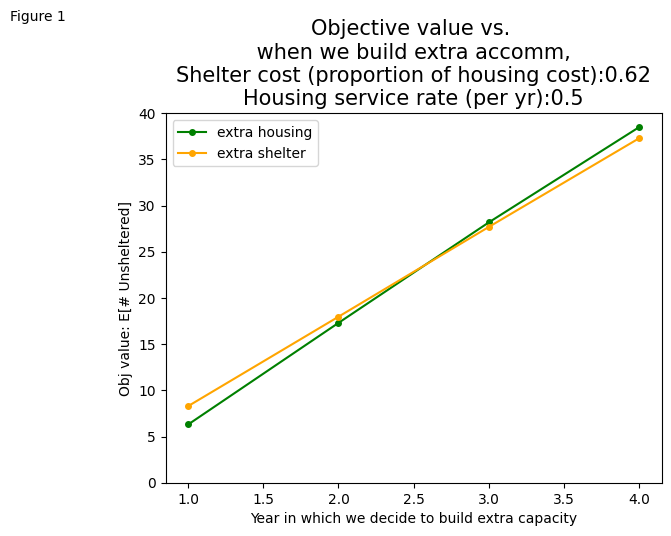

In [18]:
title1 = 'Shelter cost (proportion of housing cost):'
title2 = 'Housing service rate (per yr):'
x = [1,2,3,4]
plt.plot(x, housing_imprv_all4_obj1[0][0], color = 'green', label = 'extra housing', marker='o', markersize = 4)
plt.plot(x, shelter_imprv_all4_obj1[0][0], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
plt.title('Objective value vs. \n when we build extra accomm, \n' + 
          title1 + 
          str(round(hx/additional_shelter[0],2)) +
          '\n' + 
          title2 + 
          str(round(1/service_times[0],2)),fontsize = 15)
plt.xlabel('Year in which we decide to build extra capacity')
plt.ylabel('Obj value: E[# Unsheltered]')
plt.ylim(0,40)
plt.text(0, 50, 'Figure 1', ha='center')
plt.legend(loc = 'upper left')
plt.show()

#### Next steps

We now consider it insightful to investigate the performance of each solution above in more detail, namely to visualise the performance over time (over the 10 year model run) rather than the average performance. This is motivated by the consideration that a decision (to build housing or shelter) is influenced by the time horizon over which we are interested in the effects of the decision. 

In [19]:
# Calculate percentiles
housing_percentiles_allQ = []
shelter_percentiles_allQ = []
housing_percentiles_unshQ = []
shelter_percentiles_unshQ = []
housing_percentiles_shQ = []
shelter_percentiles_shQ = []

for yr in range(yrs_dec):
    housing_percentiles_allQ.append(qm.get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, housing_imprv_all4_obj1_p_q, 0, 0))
    shelter_percentiles_allQ.append(qm.get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, shelter_imprv_all4_obj1_p_q, 0, 0))
    housing_percentiles_unshQ.append(qm.get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, housing_imprv_all4_obj1_p_unsh, 0, 0))
    shelter_percentiles_unshQ.append(qm.get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, shelter_imprv_all4_obj1_p_unsh, 0, 0))
    housing_percentiles_shQ.append(qm.get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, housing_imprv_all4_obj1_p_sh, 0, 0))
    shelter_percentiles_shQ.append(qm.get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, shelter_imprv_all4_obj1_p_sh, 0, 0))        

#### Plot of # Unsheltered over time for all 8 solutions

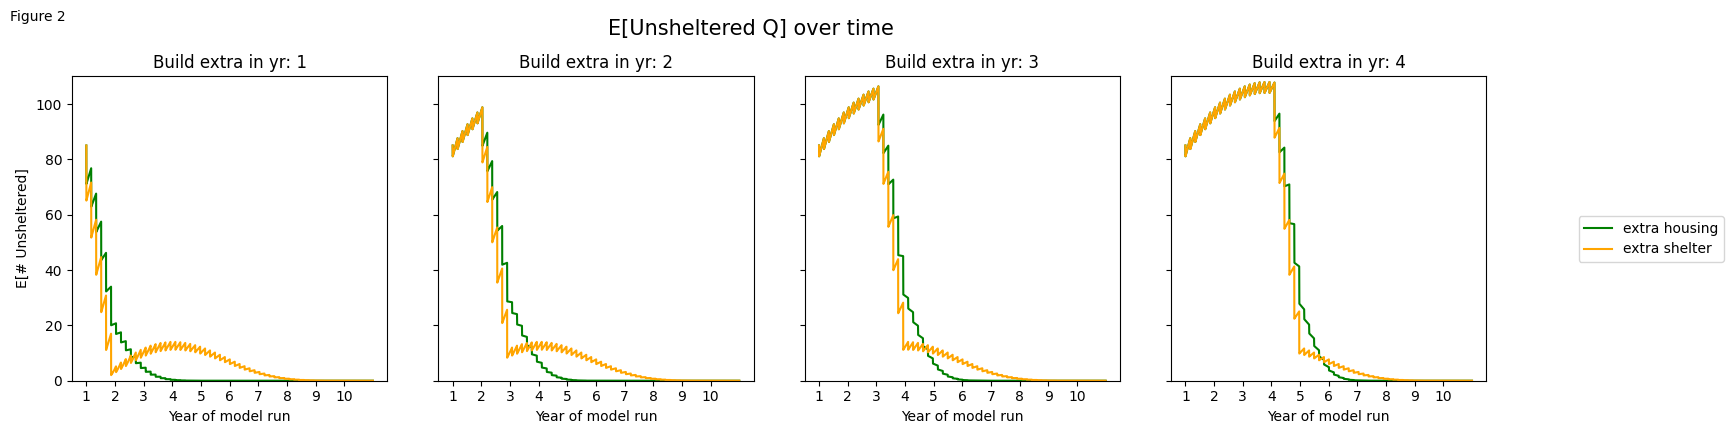

In [71]:
n_cl = yrs_dec
n_rw = 1
fig, axs = plt.subplots(n_rw, n_cl, figsize=(15, 4), sharex=True)
x = [(i+365)/365 for i in range(3650)]
for yr in range(n_cl):
    y1 = [housing_imprv_all4_obj1_qu_unsh_vs_t[0][0][yr][i] for i in range(3650)]
    y2 = [shelter_imprv_all4_obj1_qu_unsh_vs_t[0][0][yr][i] for i in range(3650)]
    line1, = axs[yr].plot(x, y1, color = 'green', label = 'extra housing')
    line2, = axs[yr].plot(x, y2, color = 'orange', label = 'extra shelter')
    # axs[yr].fill_between(x, housing_percentiles_unshQ[yr]['low'], housing_percentiles_unshQ[yr]['high'], color = 'honeydew')
    # axs[yr].fill_between(x, shelter_percentiles_unshQ[yr]['low'], shelter_percentiles_unshQ[yr]['high'], color = 'peachpuff')                        
    axs[yr].set_title('Build extra in yr: ' + str(yr+1))
    axs[yr].set_ylim(0,110)
    axs[yr].set_xlabel("Year of model run", loc = 'center')
    if yr == 0:
        axs[yr].set_ylabel("E[# Unsheltered]")

fig.legend(handles=[line1, line2], bbox_to_anchor=(1.1,0.5), loc = 'center') 
fig.tight_layout()
                        
plt.suptitle('E[Unsheltered Q] over time', fontsize = 15, y = 1.05)
plt.xticks(np.arange(min(x), max(x), 1.0))
plt.text(-40, 130, 'Figure 2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

We see here in Figure 2 that the benefits of spending our extra budget on shelter are in the short term, quickly bringing down the size of the unsheltered Q. In the long run, having extra shelter, the size of the unsheltered Q takes time to come down to zero since these extra shelters do not increase the rate of people leaving the system. The benefits of spending our extra budget on housing are not immediate, since only 60 extra can be bought so they do less for immediately taking people out of the unsheltered Q. However, in the long run they increase the rate of people leaving the system and therefore more quickly bring down the size of the unsheltered Q to zero. Moving from left to right in the graphs above, one can see that as the decision is delayed, the long term benefit of extra housing over extra shelter (the gap between the green and orange lines in the right hand side of each chart) goes from large to small, so we go from prefering housing to prefering shelter (as summarised in Figure 1 above)

We comment here that if we were to let the model run for 20, 30 or more years, because by this stage the expected value of the unsheltered Q is zero (since the total service rate well exceeds the arrival rate), we would not learn anything more and this would not change our overall preference for housing or shelter. If we were to consider a system which was unstable for a longer period, then running the model for longer may affect the decision. Such an experiment could be run, but we would have to be careful in the chosen size of the state space. 

#### Visualising the whole queue (unsheltered + sheltered)

The charts in Figure 3 below show the performance of the same solutions, but now looking at the size of the 'whole Q' i.e. sheltered + unsheltered. Clearly, building shelters does nothing to change this metric, however building houses does increase the service rate of the system and thus the size of the whole Q. 

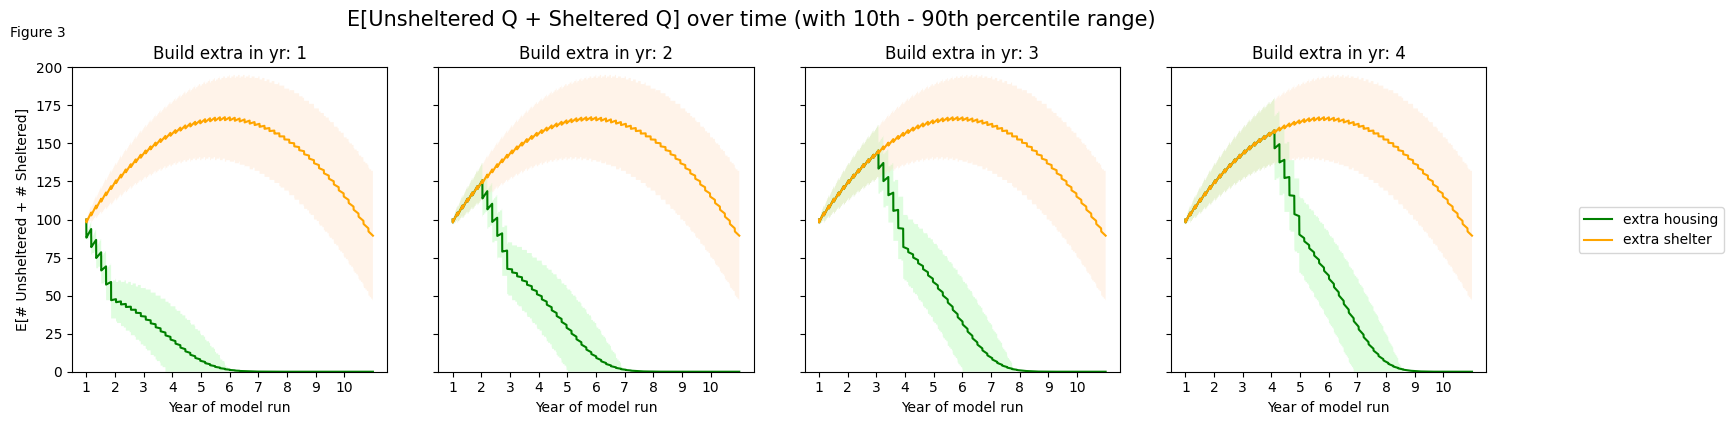

In [79]:
n_cl = yrs_dec
n_rw = 1
fig, axs = plt.subplots(n_rw, n_cl, figsize=(15, 4), sharex=True)
x = [(i+365)/365 for i in range(3650)]
for yr in range(n_cl):
    y1 = [housing_imprv_all4_obj1_qu_unsh_vs_t[0][0][yr][i] + housing_imprv_all4_obj1_qu_sh_vs_t[0][0][yr][i] for i in range(3650)]
    y2 = [shelter_imprv_all4_obj1_qu_unsh_vs_t[0][0][yr][i] + shelter_imprv_all4_obj1_qu_sh_vs_t[0][0][yr][i] for i in range(3650)]
    line1, = axs[yr].plot(x, y1, color = 'green', label = 'extra housing')
    line2, = axs[yr].plot(x, y2, color = 'orange', label = 'extra shelter')
    axs[yr].fill_between(x, housing_percentiles_allQ[yr]['low'], housing_percentiles_allQ[yr]['high'], facecolor = 'palegreen', alpha = 0.3)
    axs[yr].fill_between(x, shelter_percentiles_allQ[yr]['low'], shelter_percentiles_allQ[yr]['high'], facecolor = 'peachpuff', alpha = 0.3)                        
    axs[yr].set_title('Build extra in yr: ' + str(yr+1))
    axs[yr].set_ylim(0,200)
    axs[yr].set_xlabel("Year of model run", loc = 'center')
    if yr == 0:
        axs[yr].set_ylabel("E[# Unsheltered + # Sheltered]")

fig.legend(handles=[line1, line2], bbox_to_anchor=(1.1,0.5), loc = 'center') 
fig.tight_layout()
                        
plt.suptitle('E[Unsheltered Q + Sheltered Q] over time (with 10th - 90th percentile range)', fontsize = 15, y = 1.05)
plt.xticks(np.arange(min(x), max(x), 1.0))
plt.text(-40, 220, 'Figure 3')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

The charts in Figure 3 above illustrate that if we are considering the unsheltered and sheltered queue combined, then it is only by building houses that we can improve the performance of the system. It is now insightful to look separately at the changing size of the sheltered queue only, for our 8 solutions, as shown below in Figure 4. 

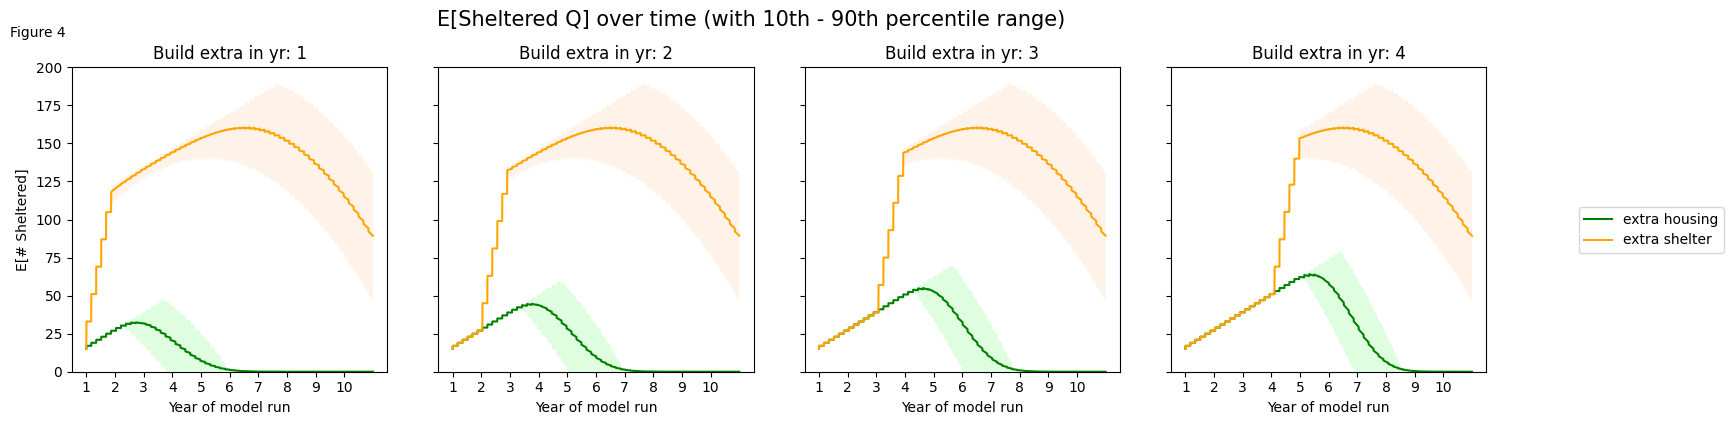

In [80]:
n_cl = yrs_dec
n_rw = 1
fig, axs = plt.subplots(n_rw, n_cl, figsize=(15, 4), sharex=True)
x = [(i+365)/365 for i in range(3650)]
for yr in range(n_cl):
    y1 = [housing_imprv_all4_obj1_qu_sh_vs_t[0][0][yr][i] for i in range(3650)]
    y2 = [shelter_imprv_all4_obj1_qu_sh_vs_t[0][0][yr][i] for i in range(3650)]
    line1, = axs[yr].plot(x, y1, color = 'green', label = 'extra housing')
    line2, = axs[yr].plot(x, y2, color = 'orange', label = 'extra shelter')
    axs[yr].fill_between(x, housing_percentiles_shQ[yr]['low'], housing_percentiles_shQ[yr]['high'], facecolor = 'palegreen', alpha = 0.3)
    axs[yr].fill_between(x, shelter_percentiles_shQ[yr]['low'], shelter_percentiles_shQ[yr]['high'], facecolor = 'peachpuff', alpha = 0.3)                        
    axs[yr].set_title('Build extra in yr: ' + str(yr+1))
    axs[yr].set_ylim(0,200)
    axs[yr].set_xlabel("Year of model run", loc = 'center')
    if yr == 0:
        axs[yr].set_ylabel("E[# Sheltered]")

fig.legend(handles=[line1, line2], bbox_to_anchor=(1.1,0.5), loc = 'center') 
fig.tight_layout()
                        
plt.suptitle('E[Sheltered Q] over time (with 10th - 90th percentile range)', fontsize = 15, y = 1.05)
plt.xticks(np.arange(min(x), max(x), 1.0))
plt.text(-40, 220, 'Figure 4')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

As the orange curves in Figure 4 illustrate, as soon as we build extra shelter instead of extra housing, the size of the sheltered Q rises as those shelters fill up. The size of the sheltered Q continues to rise as we continue to build a baseline amount of shelters each year, but eventually it falls due to the increased service rate caused by building the baseline amount of extra housing each year. The green curves illustrate that building extra housing (instead of extra shelter) suppresses the amount of sheltered space which can be occupied, and eventually brings it down to zero as the increased service rate enables the whole Q (sheltered and unsheltered) to be cleared. 

It is interesting to see that in the solutions we have considered, the differences in the effects on the unsheltered Q are small relative to the differences in the effects on the sheltered Q, and therefore the Q as a whole. 